In [1]:
from datasets import load_dataset
from transformers import EarlyStoppingCallback, IntervalStrategy

train_ds = load_dataset("imagefolder", data_dir="data/original/urbansound8k", split="train")


# split up training into training + validation
splits = train_ds.train_test_split(test_size=0.3)
train_val_ds = splits['train']
test_ds = splits['test']

splits = train_val_ds.train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']


print(len(train_ds),len(test_ds),len(val_ds))

Resolving data files:   0%|          | 0/8733 [00:00<?, ?it/s]

Using custom data configuration default-dc4b097253cef5b2
Found cached dataset imagefolder (/home/ubuntu/.cache/huggingface/datasets/imagefolder/default-dc4b097253cef5b2/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


5500 2620 612


In [27]:
# !pip install datasets
# !pip install Pillow
# !pip install transformers
# !pip install torch torchvision torchaudio
# !pip install -U scikit-learn
# !pip install tensorboard
# !pip install matplotlib

     |████████████████████████████████| 9.4 MB 24.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 77.5 MB/s eta 0:00:01
     |████████████████████████████████| 965 kB 92.4 MB/s eta 0:00:01
     |████████████████████████████████| 295 kB 95.0 MB/s eta 0:00:01


In [3]:
train_ds

Dataset({
    features: ['image', 'classID', 'class'],
    num_rows: 5500
})

In [4]:
import json

with open('data/label2id.json') as f:
    label2id = json.load(f)

with open('data/id2label.json') as f:
    id2label = json.load(f)

id2label = {int(key):value for key,value in id2label.items()}
id2label

{0: 'air_conditioner',
 1: 'car_horn',
 2: 'children_playing',
 3: 'dog_bark',
 4: 'drilling',
 5: 'engine_idling',
 6: 'gun_shot',
 7: 'jackhammer',
 8: 'siren',
 9: 'street_music'}

In [5]:

from transformers import ViTFeatureExtractor

feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")


In [6]:
feature_extractor.size

{'height': 224, 'width': 224}

In [7]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(224),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(224),
            CenterCrop(224),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

In [8]:
# Set the transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

In [9]:
val_ds[:2]

{'image': [<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=496x369>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=496x369>],
 'classID': [7, 3],
 'class': ['jackhammer', 'dog_bark'],
 'pixel_values': [tensor([[[-0.9843, -0.9765, -0.9765,  ..., -0.9686, -0.9686, -0.9765],
           [-0.8902, -0.8667, -0.8588,  ..., -0.8667, -0.8588, -0.8510],
           [-0.5608, -0.4745, -0.4275,  ..., -0.5059, -0.4745, -0.3961],
           ...,
           [ 0.9608,  0.9529,  0.9451,  ...,  0.9451,  0.9529,  0.9529],
           [ 0.9529,  0.9373,  0.9294,  ...,  0.8902,  0.8980,  0.9294],
           [ 0.9373,  0.9137,  0.8902,  ...,  0.7333,  0.7490,  0.8902]],
  
          [[-0.9843, -0.9843, -0.9765,  ..., -0.9686, -0.9686, -0.9765],
           [-0.9608, -0.9608, -0.9529,  ..., -0.9529, -0.9529, -0.9529],
           [-0.8824, -0.8745, -0.8745,  ..., -0.8824, -0.8824, -0.8588],
           ...,
           [ 0.0431,  0.0039, -0.0353,  ..., -0.0431, -0.0275, -0.0275],
           [-0.043

In [10]:

from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["classID"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

In [11]:

batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


In [12]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  num_labels=10,
                                                  id2label=id2label,
                                                  label2id=label2id)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
# Changing the number of attention heads from 12 -> 10 -- Dropping 2 heads
model.config.num_attention_heads = 10

NameError: name 'model' is not defined

In [3]:
model.config

NameError: name 'model' is not defined

In [15]:
from transformers import file_utils
print(file_utils.default_cache_path)

/home/ubuntu/.cache/huggingface/hub


In [16]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    f"test-urbansound8k-10",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=13,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

In [17]:
from datasets import load_metric
import numpy as np

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

/tmp/ipykernel_10311/1052707893.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [18]:
import torch

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=5)]
)

In [19]:
train_ds

Dataset({
    features: ['image', 'classID', 'class'],
    num_rows: 5500
})

In [20]:

# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir logs/

In [22]:
trainer.train()

***** Running training *****
  Num examples = 5500
  Num Epochs = 50
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps = 27500
  Number of trainable parameters = 85806346


Epoch,Training Loss,Validation Loss,Accuracy
1,0.923400,0.654688,0.861111
2,0.706500,0.543355,0.857843
3,0.586700,0.460020,0.887255
4,0.511300,0.345101,0.911765
5,0.467300,0.327583,0.911765
6,0.436300,0.332422,0.906863
7,0.386500,0.319718,0.919935
8,0.388900,0.247142,0.936275
9,0.337800,0.265344,0.931373
10,0.311900,0.221502,0.946078


***** Running Evaluation *****
  Num examples = 612
  Batch size = 4
Saving model checkpoint to test-cifar-10/checkpoint-550
Configuration saved in test-cifar-10/checkpoint-550/config.json
Model weights saved in test-cifar-10/checkpoint-550/pytorch_model.bin
Image processor saved in test-cifar-10/checkpoint-550/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 612
  Batch size = 4
Saving model checkpoint to test-cifar-10/checkpoint-1100
Configuration saved in test-cifar-10/checkpoint-1100/config.json
Model weights saved in test-cifar-10/checkpoint-1100/pytorch_model.bin
Image processor saved in test-cifar-10/checkpoint-1100/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 612
  Batch size = 4
Saving model checkpoint to test-cifar-10/checkpoint-1650
Configuration saved in test-cifar-10/checkpoint-1650/config.json
Model weights saved in test-cifar-10/checkpoint-1650/pytorch_model.bin
Image processor saved in test-cifar-10/checkpoint-1650/pre

KeyboardInterrupt: 

In [23]:
outputs = trainer.predict(test_ds)

***** Running Prediction *****
  Num examples = 2620
  Batch size = 4


In [25]:
print(outputs.metrics)

{'test_loss': 0.1933828741312027, 'test_accuracy': 0.9484732824427481, 'test_runtime': 44.2499, 'test_samples_per_second': 59.209, 'test_steps_per_second': 14.802}


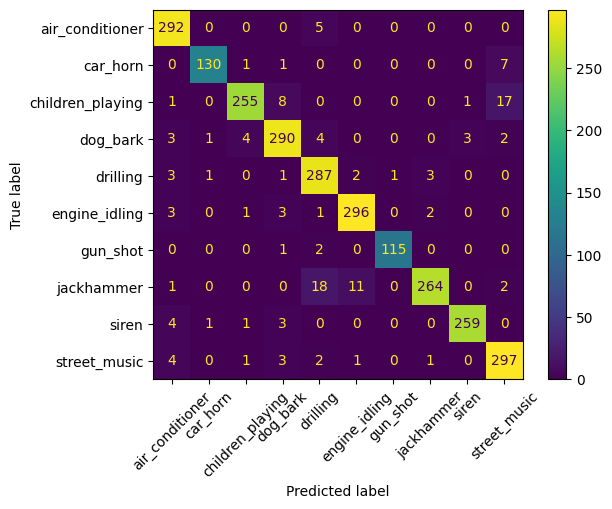

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = id2label.values()
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [31]:
model.save_pretrained("/home/ubuntu/models/AudioViT_Ablated_Multi_Head_Attention_Nodes_10")

Configuration saved in /home/ubuntu/models/AudioViT_Ablated_Multi_Head_Attention_Nodes_10/config.json
Model weights saved in /home/ubuntu/models/AudioViT_Ablated_Multi_Head_Attention_Nodes_10/pytorch_model.bin
